In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit                

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls

In [4]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

In [5]:
'''#directories and files 
data_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/'
data_file_2015 ='Bd2JpsiKS_data_2015_flattened_sw.root'
data_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsiks/sweights/'
data_file_2016 ='Bd2JpsiKS_data_2016_flattened_sw.root'

mc_dir = '/fhgfs/users/chasenberg/mc/2015/jpsiks/dimuon/flattened/'
mc_file = 'Bd2JpsiKS_dimuon_mc_2015_flat.root'

data_dir_2015 = os.path.join(data_dir_2015, data_file_2015)
data_dir_2016 = os.path.join(data_dir_2016, data_file_2016)
mc_dir = os.path.join(mc_dir, mc_file)'''

"#directories and files \ndata_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/'\ndata_file_2015 ='Bd2JpsiKS_data_2015_flattened_sw.root'\ndata_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsiks/sweights/'\ndata_file_2016 ='Bd2JpsiKS_data_2016_flattened_sw.root'\n\nmc_dir = '/fhgfs/users/chasenberg/mc/2015/jpsiks/dimuon/flattened/'\nmc_file = 'Bd2JpsiKS_dimuon_mc_2015_flat.root'\n\ndata_dir_2015 = os.path.join(data_dir_2015, data_file_2015)\ndata_dir_2016 = os.path.join(data_dir_2016, data_file_2016)\nmc_dir = os.path.join(mc_dir, mc_file)"

In [6]:
'''#Treename for data
tree_data = 'Bd2JpsiKs'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5350&B0_FitDaughtersConst_M>5220&B0_BKGCAT==0&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|(B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1))'
tree_mc = 'Bd2JpsiKs'
#Read only mass of MC
variables_mc = 'B0_FitDaughtersConst_M'''

"#Treename for data\ntree_data = 'Bd2JpsiKs'\n#criteria and information for read in mc\ncut_string_mc = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5350&B0_FitDaughtersConst_M>5220&B0_BKGCAT==0&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|(B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1))'\ntree_mc = 'Bd2JpsiKs'\n#Read only mass of MC\nvariables_mc = 'B0_FitDaughtersConst_M"

Build minimal ROOT File only for determining Ipatia parameters
----------------------------------------------------

In [7]:
'''signal_dataframe = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=True)
signal_dataframe = signal_dataframe.replace([np.inf, -np.inf], np.nan)
signal_dataframe = signal_dataframe.dropna()
signal_dataframe.to_root('/fhgfs/users/chasenberg/mc/2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_mc_2016_flat_cuts_BDT_cut.root')'''

"signal_dataframe = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=True)\nsignal_dataframe = signal_dataframe.replace([np.inf, -np.inf], np.nan)\nsignal_dataframe = signal_dataframe.dropna()\nsignal_dataframe.to_root('/fhgfs/users/chasenberg/mc/2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_mc_2016_flat_cuts_BDT_cut.root')"

In [8]:
#Mass variable
B0_M = RooRealVar("B0_FitDaughtersConst_M", "B0_M", 5280, "MeV")
mass = RooRealVar("B0_FitDaughtersConst_M", "Mass(J/psi K_{S})", 5280,5220, 5350, "MeV")

In [9]:
# Read data and fit it
data = ROOT.TFile('/fhgfs/users/chasenberg/mc/2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_mc_2016_flat_cuts_BDT_cut.root')
tree_data = data.Get('default') 
ntupleVarSet =  RooArgSet(mass) 

In [10]:
dataset = RooDataSet('data1','data1',tree_data,ntupleVarSet)

Build Ipatia mass model
--------------------------------------------

In [17]:
postfix = ''

par_ipatia_zeta  = RooRealVar('par_ipatia_zeta'  + postfix,  'par_ipatia_zeta'  + postfix, 2.8, 0.3, 5.3)
par_ipatia_fb    = RooRealVar('par_ipatia_fb'    + postfix,    'par_ipatia_fb'  + postfix, 0., 0., 0.)
par_ipatia_l     = RooRealVar('par_ipatia_l'     + postfix,     'par_ipatia_l'  + postfix, 1., 1., 1.)
par_ipatia_m     = RooRealVar('par_ipatia_m'     + postfix,     'par_ipatia_m'  + postfix, 5280, 5220., 5350.,)
par_ipatia_sigma = RooRealVar('par_ipatia_sigma' + postfix, 'par_ipatia_sigma'  + postfix, 8., 2., 100.)
par_ipatia_a1    = RooRealVar('par_ipatia_a1'    + postfix,     'par_ipatia_a1' + postfix, 2.1, 0.01, 4)
par_ipatia_a2    = RooRealVar('par_ipatia_a2'    + postfix,     'par_ipatia_a2' + postfix, 2.1, 0.01, 4)
par_ipatia_n1    = RooRealVar('par_ipatia_n1'    + postfix,     'par_ipatia_n1' + postfix, 3.8, 0.00001, 150.)
par_ipatia_n2    = RooRealVar('par_ipatia_n2'    + postfix,     'par_ipatia_n2' + postfix, 7.0, 0.00001, 150.)

pdf_mass_ipatia  = ROOT.RooIpatia2('pdf_mass_ipatia', 'pdf_mass_ipatia', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                               par_ipatia_sigma, par_ipatia_m, par_ipatia_a1, par_ipatia_n1,
                               par_ipatia_a2, par_ipatia_n2)
    
ROOT.SetOwnership( pdf_mass_ipatia, False )
ROOT.SetOwnership( par_ipatia_zeta, False )
ROOT.SetOwnership( par_ipatia_fb, False )
ROOT.SetOwnership( par_ipatia_l, False )
ROOT.SetOwnership( par_ipatia_m, False )
ROOT.SetOwnership( par_ipatia_sigma, False )
ROOT.SetOwnership( par_ipatia_a1, False )
ROOT.SetOwnership( par_ipatia_n1, False )
ROOT.SetOwnership( par_ipatia_a2, False )
ROOT.SetOwnership( par_ipatia_n2, False )

sig_yield = RooRealVar('sig_yield' + postfix, 'sig_yield' + postfix, 99000, 0, 110000)
ROOT.SetOwnership( sig_yield, False )

sig_pdf_ext = RooExtendPdf('sig_pdf_ext' + postfix, 'sig_pdf_ext' + postfix, pdf_mass_ipatia, sig_yield)
ROOT.SetOwnership( sig_pdf_ext, False )
 
exp_a = RooRealVar('exp_a' + postfix, 'exp_a' + postfix, -0.001, -0.01, -0.00001)
exp   = RooExponential('exp' + postfix, 'exp' + postfix, mass, exp_a)
bkg_pdf = exp
bkg_yield = RooRealVar('bkg_yield' + postfix, 'bkg_yield' + postfix, 0, 0, 0)
ROOT.SetOwnership( exp_a, False )
ROOT.SetOwnership( bkg_pdf, False )
ROOT.SetOwnership( bkg_yield, False)

bkg_pdf_ext = RooExtendPdf('bkg_pdf_ext' + postfix, 'bkg_pdf_ext' + postfix, bkg_pdf, bkg_yield)
ROOT.SetOwnership( bkg_pdf_ext, False)

par_ipatia_m_bs_shift = RooRealVar("par_ipatia_m_bs_shift" + postfix, "par_ipatia_m_bs_shift" + postfix, 87.0, 50.0, 100.0)
par_ipatia_m_bs = RooFormulaVar("par_ipatia_m_bs" + postfix, "par_ipatia_m_bs" + postfix, "@0+@1", RooArgList(par_ipatia_m, par_ipatia_m_bs_shift))
#par_ipatia_m_bs = RooRealVar("par_ipatia_m_bs"    + postfix,    "par_ipatia_m_bs" + postfix,    5366, 5300., 5400.,)
                    
pdf_mass_ipatia_bs  = ROOT.RooIpatia2('pdf_mass_ipatia_bs', 'pdf_mass_ipatia_bs', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                                   par_ipatia_sigma, par_ipatia_m_bs, par_ipatia_a1, par_ipatia_n1, par_ipatia_a2, par_ipatia_n2)
    
bs_yield = RooRealVar('bs_yield' + postfix, 'bs_yield' + postfix, 0, 0, 0)
ROOT.SetOwnership( par_ipatia_m_bs_shift, False )
ROOT.SetOwnership( par_ipatia_m_bs, False)
ROOT.SetOwnership( bs_yield, False)
ROOT.SetOwnership( pdf_mass_ipatia_bs, False)

bs_pdf_ext = RooExtendPdf('bs_pdf_ext' + postfix, 'bs_pdf_ext' + postfix, pdf_mass_ipatia_bs, bs_yield)
ROOT.SetOwnership( bs_pdf_ext, False)

data_model = RooAddPdf('model' + postfix, 'model' + postfix, RooArgList(sig_pdf_ext, bkg_pdf_ext, bs_pdf_ext))
ROOT.SetOwnership( data_model, False )
    

In [18]:
#Fit model to dataset
data_model.fitTo(dataset, ROOT.RooFit.Save(True)) 

<ROOT.RooFitResult object ("fitresult_model_data1") at 0x8c442c0>

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


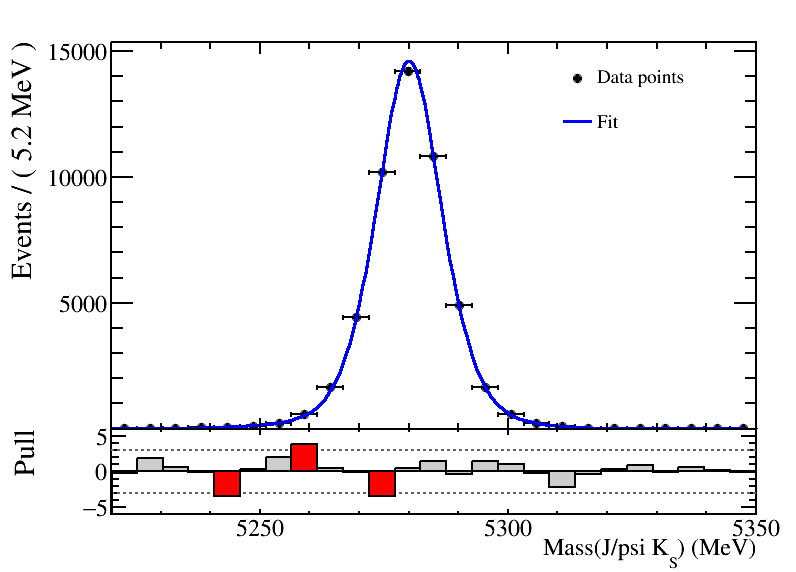

In [19]:
# Prepare frame
%matplotlib inline  
import ROOT
frame = mass.frame(ROOT.RooFit.Bins(25))

dataset.plotOn(frame, ROOT.RooFit.Name("data1"))

data_model.plotOn( frame , ROOT.RooFit.Components("signal"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kRed))
data_model.plotOn( frame , ROOT.RooFit.Components("background"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
data_model.plotOn(frame, ROOT.RooFit.Name("fit"))
### Add additional informations to the plot
text_size = 0.035
# Create TLegend
legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9, '')
legend.AddEntry(frame.findObject('data1'), "Data points", "p");
legend.AddEntry(frame.findObject('fit'), 'Fit', 'l')
legend.SetTextSize(text_size)

# Plot pulls
can, _ = plot_pulls('test', frame, legend=legend)#, latex=latex)
can.SaveAs("/home/chasenberg/repos/b2cc_sin2beta/notebooks/mass_fit/plots/jpsiks/2015/ipatia/B0_Mass.pdf")
can  # To display plot in notebooks

In [20]:
sig_pdf = data_model.getComponents().find('sig_pdf_ext')
bkg_pdf = data_model.getComponents().find('bkg_pdf_ext')

In [21]:

varnames = []
varnames.append('par_ipatia_a1')
varnames.append('par_ipatia_a2')
varnames.append('par_ipatia_n1')
varnames.append('par_ipatia_n2')
varnames.append('par_ipatia_l')
varnames.append('par_ipatia_sigma')
varnames.append('par_ipatia_m')
varnames.append('par_ipatia_m_bs_shift')
varnames.append('par_ipatia_fb')
varnames.append('exp_a')

for varname in varnames:
    var = args.find(varname)
    shape_dict[varname+'_value'] = var.getValV()
    shape_dict[varname+'_errlo'] = var.getErrorLo()
    shape_dict[varname+'_errhi'] = var.getErrorHi()

NameError: name 'args' is not defined

In [22]:
sig_yield.getValV()

49994.60294079673